In [3]:
import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)


Tensorflow Version: 2.7.0
Cleverhans Version: 4.0.0-edc15c6ec93c96562523dc42ae33c9e7


In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',loss= 'sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/10
1500/1500 [==============================] - 6s 3ms/step - loss: 0.4310 - accuracy: 0.8774 - val_loss: 0.2147 - val_accuracy: 0.9358
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1957 - accuracy: 0.9434 - val_loss: 0.1725 - val_accuracy: 0.9477
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1531 - accuracy: 0.9552 - val_loss: 0.1535 - val_accuracy: 0.9544
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1295 - accuracy: 0.9624 - val_loss: 0.1427 - val_accuracy: 0.9579
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1115 - accuracy: 0.9661 - val_loss: 0.1390 - val_accuracy: 0.9584
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0996 - accuracy: 0.9699 - val_loss: 0.1339 - val_accuracy: 0.9613
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0902 - accuracy: 0.9731 - val_loss: 0.1235 - val_accuracy:

# Implementing the FGSM attack using fast_gradient_method()

In [6]:
# fast_gradient_method(model_fn, x, eps, norm, clip_min=None, clip_max=None, y=None, targeted=False, sanity_checks=False)

#model_fn: a callable that takes an input tensor and returns the model logits
#x: input_tensor
#eps: epsilon (dictates the "strength" of the distortion created)
#norm: Order of the norm (mimics NumPy). Possible values: np.inf, 1 or 2.
#clip_min: (optional, default=None) float. Minimum float value for adversarial example components.
#clip_max: (optional, default=None) float. Maximum float value for adversarial example components
#y: (optional, default=None) Tensor with true labels. If targeted is true, then provide the target label. Otherwise, only provide this parameter if you'd like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect (explained in this paper).
#targeted: (optional, default=False) bool. Is the attack targeted or untargeted? Untargeted, the default, will try to make the label incorrect. Targeted will instead try to move in the direction of being more like y.
#param sanity_checks: (optional, default=False) bool, if True, include asserts (Turn them off to use less runtime / memory or for unit tests that intentionally pass strange input)

In [7]:
# Import the attack
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method


#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [8]:
random_index = np.random.randint(test_images.shape[0])

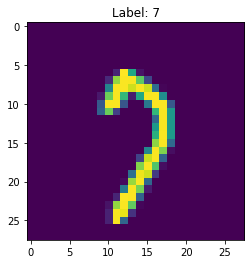

In [9]:
#Choose a random image to attack from the test set

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)))
plt.title("Label: {}".format(original_label[0]))

plt.show()

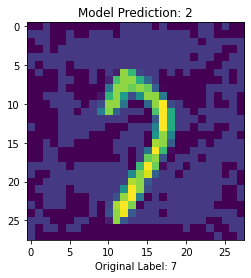

In [10]:
#Non-targeted FGSM attack

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

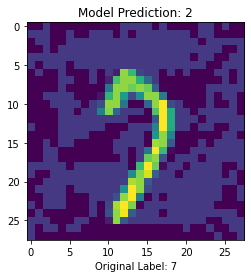

In [12]:
#Targeted FGSM Attack

epsilon = 0.1
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 6

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

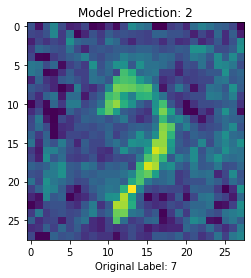

In [13]:
#Checking the PGD attack - untargeted

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

epsilon = 0.5
epsilon_iter = 0.02
nb_iter = 50

adv_example_untargeted_label = projected_gradient_descent(logits_model, tf.cast(original_image, dtype=tf.float32), epsilon,epsilon_iter, nb_iter, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

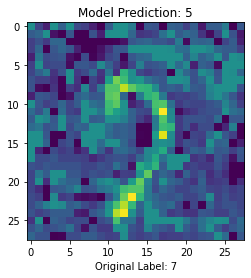

In [14]:
#Checking the PGD attack - targeted

epsilon = 0.5
epsilon_iter = 0.02
nb_iter = 50
target = 5

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_untargeted_label = projected_gradient_descent(logits_model, tf.cast(original_image, dtype=tf.float32), epsilon,epsilon_iter, nb_iter, np.inf,y=target_label,targeted=True)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

In [35]:
#C&W attack untargeted attack

#from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2

#epsilon = 0.1


#adv_example_untargeted_label = carlini_wagner_l2(logits_model,tf.cast(original_image,dtype=tf.float32))

#adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
#plt.figure()
#plt.grid(False)

#plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
#plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
#plt.xlabel("Original Label: {}".format(original_label[0]))

#plt.show()

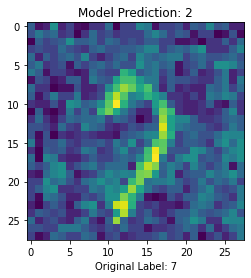

In [39]:
#BIM attack untargeted attack

from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method

epsilon = 0.5
epsilon_iter = 0.05
nb_iter = 20

adv_example_untargeted_label = basic_iterative_method(logits_model, tf.cast(original_image, dtype=tf.float32), epsilon,epsilon_iter, nb_iter, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

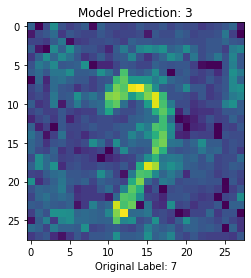

In [40]:
#Checking the PGD attack - untargeted

from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method

epsilon = 0.5
epsilon_iter = 0.02
nb_iter = 50
target = 3

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_untargeted_label = basic_iterative_method(logits_model, tf.cast(original_image, dtype=tf.float32), epsilon,epsilon_iter, nb_iter, np.inf, y=target_label,targeted=True)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()